In [1]:
# Inline plotting for Jupyter notebooks
%matplotlib inline

# Python standard libraries
import os
import cv2
from glob import glob
from itertools import product
from PIL import Image

# Data manipulation and visualization libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# PyTorch librariesd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from torch.autograd import Variable

# Scikit-learn libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Ensure reproducibility
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)

In [2]:
# Selected model for training
# Supported models: 'resnet50', 'vgg11', 'densenet121'
model_name = "resnet50"

# Dataset directory
data_dir = './dataset'

# Retrieve all image file paths in subdirectories with a '.jpg' extension
ham10000_images = glob(os.path.join(data_dir, '*', '*.jpg'))

# Create a dictionary mapping image IDs (file names without extension) to their full file paths
imageid_path_dict = {
    os.path.splitext(os.path.basename(image_path))[0]: image_path
    for image_path in ham10000_images
}

# Define a dictionary mapping diagnostic codes to their corresponding lesion types
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [4]:
def compute_image_mean_and_deviation(image_paths):
    """
    Compute the mean and standard deviation of RGB channels over the dataset.

    Args:
        image_paths (list): List of file paths to the images.

    Returns:
        tuple: Means and standard deviations of the three channels (R, G, B).
    """
    img_h, img_w = 224, 224
    imgs = []
    means, stdevs = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255.

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    # Reversing BGR values to RGB
    means.reverse()
    stdevs.reverse()

    print("Normalized Mean = {}".format(means))
    print("Normalized Std = {}".format(stdevs))
    return means,stdevs

In [5]:
norm_mean, norm_std = compute_image_mean_and_deviation(ham10000_images)

100%|██████████| 11527/11527 [00:46<00:00, 247.71it/s]


(224, 224, 3, 11527)
Normalized Mean = [np.float32(0.76265204), np.float32(0.54692256), np.float32(0.5712584)]
Normalized Std = [np.float32(0.14157124), np.float32(0.15365498), np.float32(0.17101873)]


In [3]:
# Load the HAM10000 metadata CSV file into a DataFrame
df_original = pd.read_csv(os.path.join(data_dir, 'HAM10000_metadata.csv'))

# Map each image_id to its corresponding file path
df_original['path'] = df_original['image_id'].map(imageid_path_dict.get)

# Map each diagnostic code ('dx') to its corresponding lesion type
df_original['cell_type'] = df_original['dx'].map(lesion_type_dict.get)

# Encode lesion types as numerical categories
df_original['cell_type_idx'] = pd.Categorical(df_original['cell_type']).codes
df_original.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,./dataset/ham10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,./dataset/ham10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,./dataset/ham10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,./dataset/ham10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,./dataset/ham10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2


Text(0, 0.5, 'No. of People')

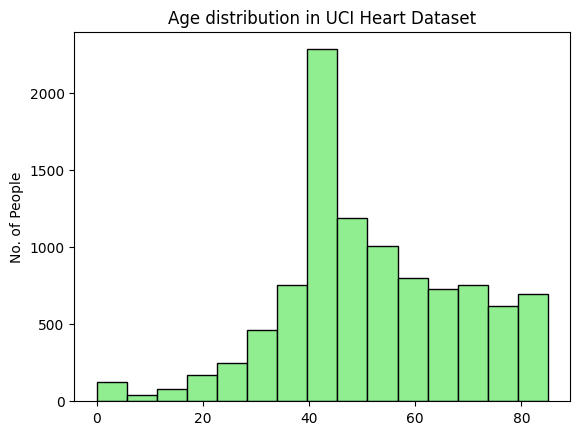

In [5]:
# Visualizing age distribution in the dataset
plt.hist(df_original["age"], bins=15, color='lightgreen', edgecolor='black')
plt.title("Age distribution in UCI Heart Dataset")
plt.ylabel("No. of People")

sex
male       5406
female     4552
unknown      57
Name: count, dtype: int64


([<matplotlib.patches.Wedge at 0x74d018d9b2c0>,
 [Text(-0.13714771892744448, 1.0914167413014144, 'male'),
  Text(0.11761205029375572, -1.0936943840148852, 'female'),
  Text(1.0998241769322061, -0.019666718978910463, 'unknown')],
 [Text(-0.07480784668769698, 0.5953182225280442, '54.0%'),
  Text(0.06415202743295766, -0.5965605730990282, '45.5%'),
  Text(0.599904096508476, -0.010727301261223888, '0.6%')])

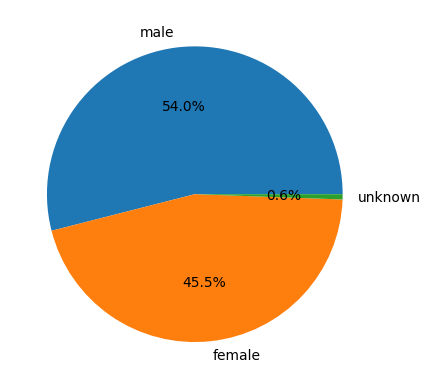

In [6]:
# Exploring sex split in the dataset
count_series = df_original["sex"].value_counts()
print(count_series)

# Plotting pie chart for gender slices
genders = df_original["sex"].unique()
counts = [count_series[gender] for gender in genders]

fig, ax = plt.subplots()
ax.pie(counts, labels=genders, autopct='%1.1f%%')

In [33]:
# Group by lesion_id to count the number of images associated with each lesion
df_undup = df_original.groupby('lesion_id').count()

# Filter out lesion_ids that are associated with only one image
df_undup = df_undup[df_undup['image_id'] == 1]

# Reset the index for the filtered DataFrame
df_undup.reset_index(inplace=True)
df_undup.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000001,1,1,1,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1,1,1,1


In [34]:
# Get the list of unique lesion IDs
unique_lesion_ids = df_undup['lesion_id'].tolist()

# Label each lesion in the original DataFrame as 'duplicated' or 'unduplicated'
df_original['duplicates'] = df_original['lesion_id'].apply(
    lambda lesion_id, unique_lesion_ids: 'unduplicated' if lesion_id in unique_lesion_ids else 'duplicated', 
    unique_lesion_ids=unique_lesion_ids
)

# Display the updated DataFrame
df_original.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,./dataset/ham10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2,duplicated
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,./dataset/ham10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2,duplicated
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,./dataset/ham10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2,duplicated
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,./dataset/ham10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2,duplicated
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,./dataset/ham10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2,duplicated


In [35]:
df_original['duplicates'].value_counts()

duplicates
unduplicated    5514
duplicated      4501
Name: count, dtype: int64

In [36]:
# Filter the dataset to keep only images without duplicates
df_undup = df_original[df_original['duplicates'] == 'unduplicated']

# Extract the target labels (cell type indices) for stratified splitting
y = df_undup['cell_type_idx']

# Split the data into training and validation sets (80-20 split) with stratification
# This ensures that the distribution of cell types is preserved in both sets
_, df_val = train_test_split(df_undup, test_size=0.2, random_state=101, stratify=y)
df_val.shape

(1103, 11)

In [37]:
df_val['cell_type_idx'].value_counts()

cell_type_idx
4    883
2     88
6     46
1     35
0     30
5     13
3      8
Name: count, dtype: int64

In [38]:
# Identify rows as 'train' or 'val'
# Create a list of validation image IDs
val_image_ids = df_val['image_id'].tolist()

# Add a new column to label each row as 'train' or 'val'
df_original['train_or_val'] = df_original['image_id'].apply(
    lambda image_id, val_image_ids: 'val' if str(image_id) in val_image_ids else 'train',
    val_image_ids=val_image_ids
)

# Filter the training set from the original dataframe
df_train = df_original[df_original['train_or_val'] == 'train']
print(len(df_train))
print(len(df_val))

8912
1103


In [39]:
df_train['cell_type_idx'].value_counts()

cell_type_idx
4    5822
6    1067
2    1011
1     479
0     297
5     129
3     107
Name: count, dtype: int64

In [40]:
df_val['cell_type'].value_counts()

cell_type
Melanocytic nevi                 883
Benign keratosis-like lesions     88
dermatofibroma                    46
Basal cell carcinoma              35
Actinic keratoses                 30
Vascular lesions                  13
Dermatofibroma                     8
Name: count, dtype: int64

In [41]:
# Copy fewer class to balance the number of 7 classes
data_aug_rate = [15, 10, 5, 50, 0, 40, 5]
augmented_data = []

# Loop through each cell type index
for i in range(7):
    if data_aug_rate[i]:
        subset = df_train[df_train['cell_type_idx'] == i]
        augmented_data.append(pd.concat([subset] * (data_aug_rate[i] - 1), ignore_index=True))

# Concatenate original and augmented data
df_train = pd.concat([df_train] + augmented_data, ignore_index=True)
df_train['cell_type'].value_counts()

cell_type
Melanocytic nevi                 5822
Dermatofibroma                   5350
dermatofibroma                   5335
Vascular lesions                 5160
Benign keratosis-like lesions    5055
Basal cell carcinoma             4790
Actinic keratoses                4455
Name: count, dtype: int64

In [42]:
# Deinfining training and testing sets
df_train = df_train.reset_index()
df_val = df_val.reset_index()

In [43]:
def set_parameter_requires_grad(model, feature_extract):
    """
    Set `requires_grad` attribute of model parameters.

    Args:
        model (nn.Module): The model whose parameters are to be modified.
        feature_extract (bool): If True, freeze all layers except the classifier.

    Returns:
        None
    """
    if feature_extract:
        for param in model.parameters():
            param.requires_grad = False

In [44]:
def create_model(model_name, num_classes, feature_extract, use_pretrained=True):
    """
    Create a deep learning model for fine-tuning or transfer learning.

    Args:
        model_name (str): The name of the model architecture to create. 
                          Supported models: 'resnet', 'vgg', 'densenet', 'inception'.
        num_classes (int): The number of output classes for the classification task.
        feature_extract (bool): If True, set requires_grad=False for feature extraction layers.
        use_pretrained (bool): If True, use a pretrained model; otherwise, initialize randomly.

    Returns:
        model_ft (nn.Module): The created and customized model.
        input_size (int): The required input image size for the model.
    """
    # Initialize variables to store the model and input size
    model_ft = None
    input_size = 0

    if model_name == "resnet50":
        """
        ResNet50 model.
        - Typical input size: 224x224.
        - Fully connected layer replaced to match the number of output classes.
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_features = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_features, num_classes)
        input_size = 224

    elif model_name == "vgg11":
        """
        VGG11 with batch normalization.
        - Typical input size: 224x224.
        - Last layer in the classifier replaced to match the number of output classes.
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_features = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_features, num_classes)
        input_size = 224

    elif model_name == "densenet121":
        """
        DenseNet121 model.
        - Typical input size: 224x224.
        - Fully connected classifier replaced to match the number of output classes.
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_features = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_features, num_classes)
        input_size = 224

    else:
        # If model name is invalid
        raise ValueError(f"Invalid model name '{model_name}'. Supported models: 'resnet50', 'vgg11', 'densenet121'.")

    return model_ft, input_size

In [45]:
num_classes = 7
feature_extract = False

# Initialize the model for this run
model_ft, input_size = create_model(
    model_name, 
    num_classes, 
    feature_extract, 
    use_pretrained=True
)

# Define the device:
device = torch.device('cuda:0')

# Put the model on the device:
model = model_ft.to(device)

/home/gkesh/Documents/Studies/Algoma/machine_learning/project/ham10000_pytorch/ham10000_pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gkesh/Documents/Studies/Algoma/machine_learning/project/ham10000_pytorch/ham10000_pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [46]:
# Transformer for training images
train_transform = transforms.Compose([
    transforms.Resize((input_size,input_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std)
])

# Transformer for testing images
val_transform = transforms.Compose([
    transforms.Resize((input_size,input_size)), 
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std)
])

In [47]:
# Define a pytorch dataloader for the HAM10000 dataset
class HAM10000(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load data and get label
        X = Image.open(self.df['path'][index])
        y = torch.tensor(int(self.df['cell_type_idx'][index]))

        if self.transform:
            X = self.transform(X)

        return X, y

In [48]:
# Define the training set using the table train_df and using our defined transitions (train_transform)
training_set = HAM10000(df_train, transform=train_transform)
train_loader = DataLoader(training_set, batch_size=32, shuffle=True, num_workers=4)

# Same for the validation set
validation_set = HAM10000(df_val, transform=train_transform)
val_loader = DataLoader(validation_set, batch_size=32, shuffle=False, num_workers=4)

In [49]:
# Adam optimizer used, use cross entropy loss as our loss function
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss().to(device)

In [ ]:
# this function is used during training process, to calculate the loss and accuracy
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [51]:
# Lists to store the cumulative training loss and accuracy across epochs
total_loss_train, total_acc_train = [], []

def train(train_loader, model, criterion, optimizer, epoch):
    """
    Trains the model for one epoch using the provided training data loader.

    Args:
        train_loader (DataLoader): DataLoader for the training dataset.
        model (nn.Module): The model to be trained.
        criterion (nn.Module): Loss function.
        optimizer (torch.optim.Optimizer): Optimizer for model parameters.
        epoch (int): The current epoch number.

    Returns:
        tuple: Average training loss and accuracy for the current epoch.
    """
    
    # Set the model to training mode (activates dropout, batchnorm, etc.)
    model.train()

    # Initialize AverageMeter objects to track loss and accuracy
    train_loss = AverageMeter()
    train_acc = AverageMeter()

    # Initialize the current iteration counter (based on the epoch)
    curr_iter = (epoch - 1) * len(train_loader)

    # Iterate through the training dataset
    for i, data in enumerate(train_loader):
        images, labels = data

        # Get the batch size (number of images in the batch)
        N = images.size(0)

        # Move data to the specified device (e.g., GPU or CPU)
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        # Zero the gradients from the previous step
        optimizer.zero_grad()

        # Perform a forward pass through the model
        outputs = None
        
        if model_name == "inceptionv3":
            outputs, _ = model(images)
        else:
            outputs = model(images)

        # Compute the loss for the current batch
        loss = criterion(outputs, labels)

        # Backpropagate the loss and update the model parameters
        loss.backward()
        optimizer.step()

        # Calculate the accuracy for the current batch
        prediction = outputs.max(1, keepdim=True)[1]
        train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item() / N)

        # Update the average training loss
        train_loss.update(loss.item())

        # Increment the iteration counter
        curr_iter += 1

        # Print training progress every 100 iterations
        if (i + 1) % 100 == 0:
            print('[epoch %d], [iter %d / %d], [train loss %.5f], [train acc %.5f]' % (
                epoch, i + 1, len(train_loader), train_loss.avg, train_acc.avg))

            # Store the running averages of loss and accuracy
            total_loss_train.append(train_loss.avg)
            total_acc_train.append(train_acc.avg)

    # Return the average loss and accuracy for the epoch
    return train_loss.avg, train_acc.avg

In [52]:
def validate(val_loader, model, criterion, optimizer, epoch):
    """
    Validates the model on the validation dataset for one epoch.

    Args:
        val_loader (DataLoader): DataLoader for the validation dataset.
        model (nn.Module): The model to be validated.
        criterion (nn.Module): Loss function.
        optimizer (torch.optim.Optimizer): Optimizer (not used during validation, kept for consistency).
        epoch (int): The current epoch number.

    Returns:
        tuple: Average validation loss and accuracy for the current epoch.
    """
    
    # Set the model to evaluation mode (disables dropout, batchnorm, etc.)
    model.eval()

    # Initialize AverageMeter objects to track validation loss and accuracy
    val_loss = AverageMeter()
    val_acc = AverageMeter()

    # Disable gradient computation to save memory and computation during validation
    with torch.no_grad():
        # Iterate through the validation dataset
        for i, data in enumerate(val_loader):
            images, labels = data

            # Get the batch size (number of images in the batch)
            N = images.size(0)

            # Move data to the specified device (e.g., GPU or CPU)
            images = Variable(images).to(device)
            labels = Variable(labels).to(device)

            # Perform a forward pass through the model
            outputs = model(images)

            # Get the predicted class by taking the index of the maximum output value
            prediction = outputs.max(1, keepdim=True)[1]

            # Calculate accuracy for the current batch and update the running total
            val_acc.update(prediction.eq(labels.view_as(prediction)).sum().item() / N)

            # Compute the loss for the current batch and update the running total
            val_loss.update(criterion(outputs, labels).item())

    # Format and print the validation results for the current epoch
    epoch_state = '[epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss.avg, val_acc.avg)
    divider = '-' * len(epoch_state)
    print(divider)
    print(epoch_state)
    print(divider)

    # Return the average validation loss and accuracy for the epoch
    return val_loss.avg, val_acc.avg

In [53]:
# Initialize the number of epochs and variables to track best validation performance
epoch_num = 10
best_val_acc = 0  # Start with an initial best validation accuracy of 0
total_loss_val, total_acc_val = [], []  # Lists to store validation loss and accuracy for each epoch

# Loop over each epoch
for epoch in range(1, epoch_num + 1):
    # Train the model for the current epoch and get the training loss and accuracy
    loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch)

    # Validate the model on the validation dataset for the current epoch and get validation loss and accuracy
    loss_val, acc_val = validate(val_loader, model, criterion, optimizer, epoch)

    # Append the validation loss and accuracy to the respective lists
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)

    # If the current validation accuracy is better than the previous best, update the best model state
    if acc_val > best_val_acc:
        best_val_acc = acc_val  # Update the best validation accuracy
        # Format the best validation state message for the current epoch
        best_val_state = 'best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val)
        
        # Print a divider, best validation record, and another divider for clarity
        divider = '*' * len(best_val_state)
        print(divider)
        print(best_val_state)
        print(divider)

[epoch 1], [iter 100 / 1124], [train loss 1.57272], [train acc 0.37844]
[epoch 1], [iter 200 / 1124], [train loss 1.46881], [train acc 0.43094]
[epoch 1], [iter 300 / 1124], [train loss 1.38196], [train acc 0.47313]
[epoch 1], [iter 400 / 1124], [train loss 1.31349], [train acc 0.50414]
[epoch 1], [iter 500 / 1124], [train loss 1.26539], [train acc 0.52725]
[epoch 1], [iter 600 / 1124], [train loss 1.22472], [train acc 0.54266]
[epoch 1], [iter 700 / 1124], [train loss 1.18626], [train acc 0.55768]
[epoch 1], [iter 800 / 1124], [train loss 1.15380], [train acc 0.56973]
[epoch 1], [iter 900 / 1124], [train loss 1.12193], [train acc 0.58153]
[epoch 1], [iter 1000 / 1124], [train loss 1.09240], [train acc 0.59288]
[epoch 1], [iter 1100 / 1124], [train loss 1.06520], [train acc 0.60259]
------------------------------------------------
[epoch 1], [val loss 0.80678], [val acc 0.70935]
------------------------------------------------
***********************************************************

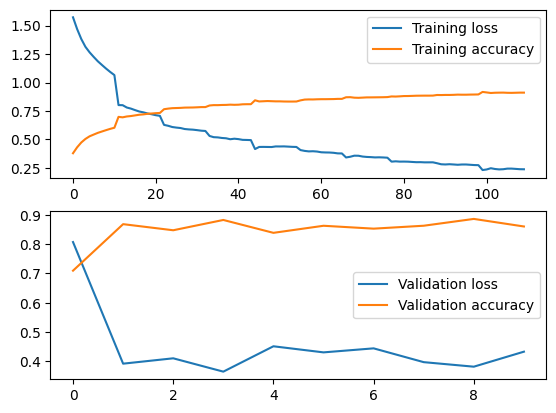

In [54]:
# Create a new figure for plotting with a specified number
fig = plt.figure(num=2)

# Create two subplots: one for training data and one for validation data
fig1 = fig.add_subplot(2, 1, 1)  # First subplot (top)
fig2 = fig.add_subplot(2, 1, 2)  # Second subplot (bottom)

# Plot the training loss and accuracy on the first subplot (fig1)
# `label` is used to specify the legend for each line
fig1.plot(total_loss_train, label='Training loss')
fig1.plot(total_acc_train, label='Training accuracy')

# Plot the validation loss and accuracy on the second subplot (fig2)
fig2.plot(total_loss_val, label='Validation loss')
fig2.plot(total_acc_val, label='Validation accuracy')

# Add legends to both subplots to indicate what each line represents
fig1.legend()  # Add legend to the first subplot (top)
fig2.legend()  # Add legend to the second subplot (bottom)

# Display the plots
plt.show()

In [7]:
def plot_confusion_matrix(
    cm, 
    classes,
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.YlOrRd
):
    """
    This function visualizes and prints the confusion matrix.
    
    Args:
        cm (array-like): Confusion matrix (2D array), where `cm[i][j]` represents
                         the number of samples that were actually in class `i` but
                         predicted as class `j`.
        classes (list): List of class labels (strings) corresponding to the rows and columns
                        of the confusion matrix.
        normalize (bool, optional): Whether to normalize the values of the confusion matrix
                                    (i.e., display proportions instead of raw counts). Default is False.
        title (str, optional): Title for the plot. Default is 'Confusion matrix'.
        cmap (matplotlib.colors.Colormap, optional): Color map to use for visualization.
                                                     Default is plt.cm.Blues.
    """
    # Display the confusion matrix as an image using the chosen colormap
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)  # Set the title of the plot
    plt.colorbar()  # Display the color bar for reference
    
    # Set tick marks at appropriate locations for each class
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)  # x-axis labels (predicted labels)
    plt.yticks(tick_marks, classes)  # y-axis labels (true labels)

    # Normalize the confusion matrix if requested
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize by row sums

    # Define the threshold for color contrast between text and background
    thresh = cm.max() / 2.  # Half the maximum value of the confusion matrix

    # Annotate the matrix with text values (the actual counts or proportions)
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        # Use white color for text on darker backgrounds, black for lighter
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    # Adjust layout to ensure the plot is neatly fitted
    plt.tight_layout()
    plt.ylabel('True label')  # Label for y-axis
    plt.xlabel('Predicted label')  # Label for x-axis

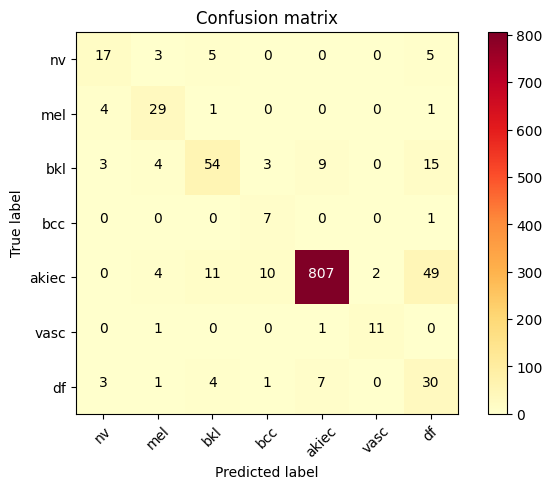

In [56]:
# Set the model to evaluation mode
model.eval()

# Initialize lists to store true labels and predicted labels
y_label = []
y_predict = []

# Disable gradient computation for validation to save memory and computations
with torch.no_grad():
    # Iterate through the validation dataset
    for i, data in enumerate(val_loader):
        images, labels = data  # Get images and their true labels
        N = images.size(0)  # Get the batch size
        images = Variable(images).to(device)  # Move images to the appropriate device (CPU or GPU)

        # Perform the forward pass to get model predictions
        outputs = model(images)

        # Get the predicted class with the highest score
        prediction = outputs.max(1, keepdim=True)[1]  # Get the class index with the highest probability

        # Extend the lists with the true and predicted labels (move them back to CPU for further use)
        y_label.extend(labels.cpu().numpy())  # True labels for comparison
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))  # Predicted labels

# Compute the confusion matrix using the true and predicted labels
cfmtx = confusion_matrix(y_label, y_predict)

# Define the class labels for plotting
plot_labels = list(lesion_type_dict.keys())

# Plot the confusion matrix with the defined class labels
plot_confusion_matrix(cfmtx, plot_labels)

In [57]:
# Generate a classification report
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

          nv       0.63      0.57      0.60        30
         mel       0.69      0.83      0.75        35
         bkl       0.72      0.61      0.66        88
         bcc       0.33      0.88      0.48         8
       akiec       0.98      0.91      0.95       883
        vasc       0.85      0.85      0.85        13
          df       0.30      0.65      0.41        46

    accuracy                           0.87      1103
   macro avg       0.64      0.76      0.67      1103
weighted avg       0.91      0.87      0.88      1103



Text(0, 0.5, 'Fraction classified incorrectly')

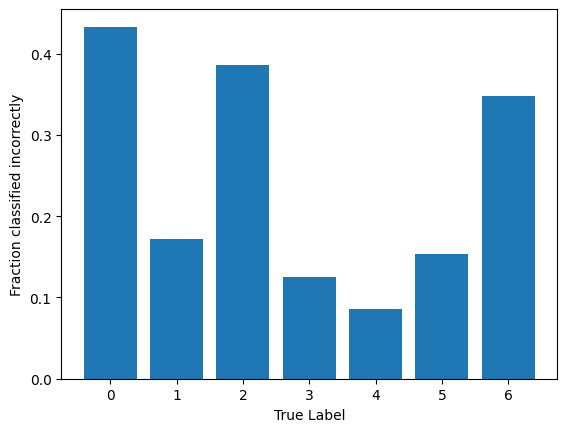

In [58]:
label_frac_error = 1 - np.diag(cfmtx) / np.sum(cfmtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

In [59]:
model_dir = f"./models/ham10000_{model_name}_model"

if not os.path.exists(model_dir):
    os.mkdir(model_dir)

model_save_path = f"{model_dir}/{model_name}_ham10000.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to ./models/ham10000_resnet50_model/resnet50_ham10000.pth


In [60]:
# Testing normal classification for image
models_trained = {
    "dense121": models.densenet121,
    "resnet50": models.resnet50,
    "vgg11": models.vgg11_bn
}

def classify_image(model_name, image_path):
    # Verifying the model
    # Reload the model architecture
    model = models_trained[model_name](pretrained=False)
    
    if model_name == "resnet50":
        model.fc = torch.nn.Linear(model.fc.in_features, 7)  # Adjust for 7 HAM10000 classes
    elif model_name == "vgg11":
        model.classifier[6] = torch.nn.Linear(model.classifier[6].in_features, 7)
    else:
        model.classifier = torch.nn.Linear(model.classifier.in_features, 7)  # Adjust for 7 HAM10000 classes
    model.load_state_dict(torch.load(f"./models/ham10000_{model_name}_model/{model_name}_ham10000.pth", map_location=device))
    model.to(device)
    model.eval()

    print("Model successfully loaded and ready for inference.")
    
    # Image preprocessing
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=norm_mean, std=norm_std)
    ])

    image = Image.open(image_path).convert("RGB")
    input_tensor = preprocess(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(input_tensor)
        predicted_class = output.argmax(dim=1).item()
    
    return predicted_class

In [61]:
# Testing out random sample image classification
image_path = f"./{data_dir}/ham10000_test_images/ISIC_0036043.jpg"  # Replace with an actual image path
predicted_class = classify_image(model_name, image_path)
print(f"Predicted class: {list(lesion_type_dict.values())[predicted_class]}")

/home/gkesh/Documents/Studies/Algoma/machine_learning/project/ham10000_pytorch/ham10000_pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gkesh/Documents/Studies/Algoma/machine_learning/project/ham10000_pytorch/ham10000_pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_2446860/3584892777.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/

Model successfully loaded and ready for inference.
Predicted class: Benign keratosis-like lesions
